In [1]:
import sys
import os

project_root = os.path.abspath(os.path.join(os.getcwd(), ".."))
if project_root not in sys.path:
    sys.path.append(project_root)

In [2]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import pandas as pd
import numpy as np
import os, gc
from rdkit import Chem
from rdkit.Chem import rdMolDescriptors, DataStructs, Descriptors, Draw
import matplotlib.pyplot as plt
import random
from tqdm import tqdm
from src import sascorer

# Defining Generator

In [ ]:
class Generator(nn.Module):
    def __init__(self, vocab_size, prop_dim, d_model=256, nhead=8, num_layers=4, max_len=128, dropout=0.1): 
        super().__init__()
        self.d_model = d_model
        self.token_embed = nn.Embedding(vocab_size, d_model)
        self.pos_embed = nn.Embedding(max_len, d_model)
        self.prop_embed = nn.Linear(prop_dim, d_model)
        self.dropout = nn.Dropout(dropout)
        encoder_layer = nn.TransformerEncoderLayer(
            d_model=d_model, nhead=nhead, dim_feedforward=512, batch_first=False, dropout=dropout  
        )
        self.transformer = nn.TransformerEncoder(encoder_layer, num_layers=num_layers)
        self.fc_out = nn.Linear(d_model, vocab_size)

    def forward(self, src, props):
        src = torch.clamp(src, 0, self.token_embed.num_embeddings - 1)
        B, L = src.shape
        tok_emb = self.token_embed(src) * (self.d_model ** 0.5)
        pos = torch.arange(L, device=src.device).unsqueeze(0)
        pos_emb = self.pos_embed(pos)
        prop_emb = self.prop_embed(props).unsqueeze(1)
        
        x = tok_emb + pos_emb + prop_emb
        x = self.dropout(x) 
        x = x.transpose(0, 1)
        tgt_mask = nn.Transformer.generate_square_subsequent_mask(L).to(src.device)
        out = self.transformer(x, mask=tgt_mask)
        out = out.transpose(0, 1) 
        logits = self.fc_out(out)
        return logits

    def sample(self, props_to_use, token_maps, max_len=128, top_k=50):
        token_to_idx, _ = token_maps
        start_token_id = token_to_idx['<START>']
        stop_token_id  = token_to_idx['<END>']
        pad_token_id   = token_to_idx['<PAD>']
    
        batch_size = props_to_use.size(0)
        device = props_to_use.device
    
        generated_seqs = torch.full((batch_size, 1), start_token_id, dtype=torch.long, device=device)
        sum_log_probs = torch.zeros(batch_size, device=device)
    
        for t in range(max_len - 1):
    
            # Forward with grads ON → log_probs have grad_fn
            logits = self.forward(generated_seqs, props_to_use)
            last_logits = logits[:, -1, :]
    
            # Top-k filtering
            v, _ = torch.topk(last_logits, top_k, dim=-1)
            last_logits[last_logits < v[:, [-1]]] = -float("inf")
    
            probs = F.softmax(last_logits, dim=-1)
            log_probs = F.log_softmax(last_logits, dim=-1)
    
            # Non-differentiable sampling
            with torch.no_grad():
                next_token = torch.multinomial(probs, num_samples=1)
    
            # Log-prob of chosen token (differentiable)
            chosen_logprob = log_probs.gather(1, next_token).squeeze(1)
    
            not_finished = (generated_seqs[:, -1] != stop_token_id).float()
            sum_log_probs += chosen_logprob * not_finished
    
            generated_seqs = torch.cat([generated_seqs, next_token], dim=1)
    
            generated_seqs = generated_seqs.detach()
    
            if not_finished.sum() == 0:
                break
    
        with torch.no_grad():
            B, L = generated_seqs.shape
            if L < max_len:
                pads = torch.full((B, max_len - L), pad_token_id, dtype=torch.long, device=device)
                generated_seqs = torch.cat([generated_seqs, pads], dim=1)
    
        return generated_seqs, sum_log_probs

# Helper functions

In [ ]:
def get_token_maps():
    token_to_idx = {
        "#": 2, "%": 3, "(": 4, ")": 5, "+": 6, "-": 7, ".": 8, "/": 9, "0": 10, "1": 11, "2": 12, "3": 13,
        "4": 14, "5": 15, "6": 16, "7": 17, "8": 18, "9": 19, "=": 20, "@": 21, "A": 22, "B": 23, "C": 24,
        "D": 25, "E": 26, "F": 27, "G": 28, "H": 29, "I": 30, "K": 31, "L": 32, "M": 33, "N": 34, "O": 35,
        "P": 36, "R": 37, "S": 38, "T": 39, "U": 40, "V": 41, "W": 42, "X": 43, "Y": 44, "Z": 45, "[": 46,
        "\\": 47, "]": 48, "a": 49, "b": 50, "c": 51, "d": 52, "e": 53, "f": 54, "g": 55, "h": 56, "i": 57,
        "k": 58, "l": 59, "m": 60, "n": 61, "o": 62, "p": 63, "r": 64, "s": 65, "t": 66, "u": 67,
        "y": 68, "<PAD>": 0, "<START>": 1, "<END>": 69
    }
    idx_to_token = {v: k for k, v in token_to_idx.items()}
    return token_to_idx, idx_to_token

token_to_idx, idx_to_token = get_token_maps()


def decode_smiles(tensor, idx_to_token):
    smiles_list = []
    for row in tensor:
        smi = ""
        for idx in row:
            idx = idx.item()
            if idx == 1: continue
            if idx == 69: break
            if idx == 0: break
            smi += idx_to_token.get(idx, '?')
        smiles_list.append(smi)
    return smiles_list

def get_props(mol):
    try:
        qed = Descriptors.qed(mol)
        sas = sascorer.calculateScore(mol)
        logp = Descriptors.MolLogP(mol)
        tpsa = Descriptors.TPSA(mol)
        mw = Descriptors.MolWt(mol)
        return [qed, sas, logp, tpsa, mw]
    except:
        return [0.0]*5

def compute_properties(smiles_list):
    props = []
    valids = []
    mols = []
    for smi in smiles_list:
        mol = Chem.MolFromSmiles(smi)
        if mol:
            mols.append(mol)
            valids.append(1)
            props.append(get_props(mol))
        else:
            mols.append(None)
            valids.append(0)
            props.append([0]*5)
    return np.array(props), np.array(valids), mols


def sample_generator(generator, props, token_maps, max_len=128):
    generator.eval()
    with torch.no_grad():
        seqs, _ = generator.sample(props, token_maps, max_len=max_len)
    return seqs.cpu()


GEN_CHECKPOINT_PATH = "../results/models_5l/generator_RL_step_5000.pt" 

VOCAB_SIZE = 70 
PROP_DIM = 5
D_MODEL = 256
N_HEAD = 8
NUM_LAYERS = 4
MAX_LEN = 128
DROPOUT = 0.1

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")
L
generator = Generator(
    vocab_size=VOCAB_SIZE, prop_dim=PROP_DIM, d_model=D_MODEL, nhead=N_HEAD, 
    num_layers=NUM_LAYERS, max_len=MAX_LEN, dropout=DROPOUT
).to(device)

gen_checkpoint = torch.load(GEN_CHECKPOINT_PATH, map_location=device, weights_only=True)
generator.load_state_dict(gen_checkpoint['model_state_dict'])
generator.eval() 
print("Loaded trained generator.")

Using device: cuda
Loaded trained generator.


c:\Users\dhanu\Desktop\bio-info data\venv\Lib\site-packages\torch\nn\modules\transformer.py:379: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(


In [ ]:

train_df = pd.read_csv("../data/processed_5l/train_properties.csv")

if "canonical" in train_df.columns:
    train_smiles = set(train_df["canonical"].astype(str).tolist())
else:
    train_smiles = set(train_df["smiles"].astype(str).tolist())

print(f"Loaded {len(train_smiles)} training SMILES for novelty comparison.")


Loaded 278937 training SMILES for novelty comparison.


In [ ]:
# SAMPLE MOLECULES

N_SAMPLES = 2000
BATCH = 32

all_smiles = []

for _ in tqdm(range(N_SAMPLES // BATCH), desc="Sampling"):
    props = torch.tensor(
        train_df.sample(BATCH)[['QED','SAS','LogP','TPSA','MolWt']].values,
        dtype=torch.float32
    ).to(device)

    seqs = sample_generator(generator, props, (token_to_idx, idx_to_token), max_len=MAX_LEN)
    smiles = decode_smiles(seqs, idx_to_token)
    all_smiles.extend(smiles)

print("Generated", len(all_smiles), "SMILES.")


Sampling: 100%|██████████| 62/62 [00:44<00:00,  1.40it/s]

Generated 1984 SMILES.


In [ ]:
# Compute validity, uniqueness, novelty
props_np, valid_arr, mols = compute_properties(all_smiles)

validity = valid_arr.mean()
unique_smiles = len(set(all_smiles))
uniqueness = unique_smiles / len(all_smiles)

novel_smiles = [s for s in all_smiles if s not in train_smiles]
novelty = len(novel_smiles) / len(all_smiles)

print("\n=== QUALITY METRICS ===")
print(f"Validity:   {validity*100:.2f}%")
print(f"Uniqueness: {uniqueness*100:.2f}%")
print(f"Novelty:    {novelty*100:.2f}%")

[11:20:26] SMILES Parse Error: syntax error while parsing: CC(C)(C)OC(=O)N[C@H](Cc1ccccc1)[C@H](O)CN1C[C@H]2CCCC[C@H]2C[C@H]2C[C@H]2CC[C@H]2C(C)CC[C@@H](C)C3(C)CC[C@]3(C)C[C@@H]2C3(C)O3(
[11:20:26] SMILES Parse Error: check for mistakes around position 127:
[11:20:26] ]3(C)C[C@@H]2C3(C)O3(
[11:20:26] ~~~~~~~~~~~~~~~~~~~~^
[11:20:26] SMILES Parse Error: Failed parsing SMILES 'CC(C)(C)OC(=O)N[C@H](Cc1ccccc1)[C@H](O)CN1C[C@H]2CCCC[C@H]2C[C@H]2C[C@H]2CC[C@H]2C(C)CC[C@@H](C)C3(C)CC[C@]3(C)C[C@@H]2C3(C)O3(' for input: 'CC(C)(C)OC(=O)N[C@H](Cc1ccccc1)[C@H](O)CN1C[C@H]2CCCC[C@H]2C[C@H]2C[C@H]2CC[C@H]2C(C)CC[C@@H](C)C3(C)CC[C@]3(C)C[C@@H]2C3(C)O3('
[11:20:26] SMILES Parse Error: extra open parentheses while parsing: CCCCCCCCC(=O)NC1CCC(OC2CCC(C)CN2)C(SSCC(C)(C)C2(SCC)CCCC2(C)CN1S(=O)(=O)C(=O)c1cccccc1
[11:20:26] SMILES Parse Error: check for mistakes around position 35:
[11:20:26] C1CCC(OC2CCC(C)CN2)C(SSCC(C)(C)C2(SCC)CCC
[11:20:26] ~~~~~~~~~~~~~~~~~~~~^
[11:20:26] SMILES Parse Error: Failed pa


=== QUALITY METRICS ===
Validity:   86.49%
Uniqueness: 99.50%
Novelty:    95.61%


[11:20:29] SMILES Parse Error: unclosed ring for input: 'CC1(C)C(=O)[C@H]2C[C@]1(O)C1=NC(=O)[C@](C)(C)[C@@H]1[C@@H]2CC[C@@]2(C)C(=O)C12CC3(C)C'
[11:20:29] Can't kekulize mol.  Unkekulized atoms: 2 5 6 7
[11:20:29] Explicit valence for atom # 3 P, 6, is greater than permitted
[11:20:29] SMILES Parse Error: extra open parentheses while parsing: CC1=CC2C(C(C)C(C)C)CCC2(C)CC(C1)CC=CC13CC=C(CC2C(C)C(C(O)C12C)C3
[11:20:29] SMILES Parse Error: check for mistakes around position 44:
[11:20:29] (C)CC(C1)CC=CC13CC=C(CC2C(C)C(C(O)C12C)C3
[11:20:29] ~~~~~~~~~~~~~~~~~~~~^
[11:20:29] SMILES Parse Error: Failed parsing SMILES 'CC1=CC2C(C(C)C(C)C)CCC2(C)CC(C1)CC=CC13CC=C(CC2C(C)C(C(O)C12C)C3' for input: 'CC1=CC2C(C(C)C(C)C)CCC2(C)CC(C1)CC=CC13CC=C(CC2C(C)C(C(O)C12C)C3'
[11:20:29] SMILES Parse Error: unclosed ring for input: 'CC(=O)O.CCCC(C)CC1CCC2C3C=CC(CC)(O)C3(C)CCC3CC(C)C12C.Cl'
[11:20:29] SMILES Parse Error: unclosed ring for input: 'CCCCCCCCC1(O)CC(OC2CCC(C)O2)C2OC(C)(C)CC2C3CCCC(O2)C3C1C3'
[11:2

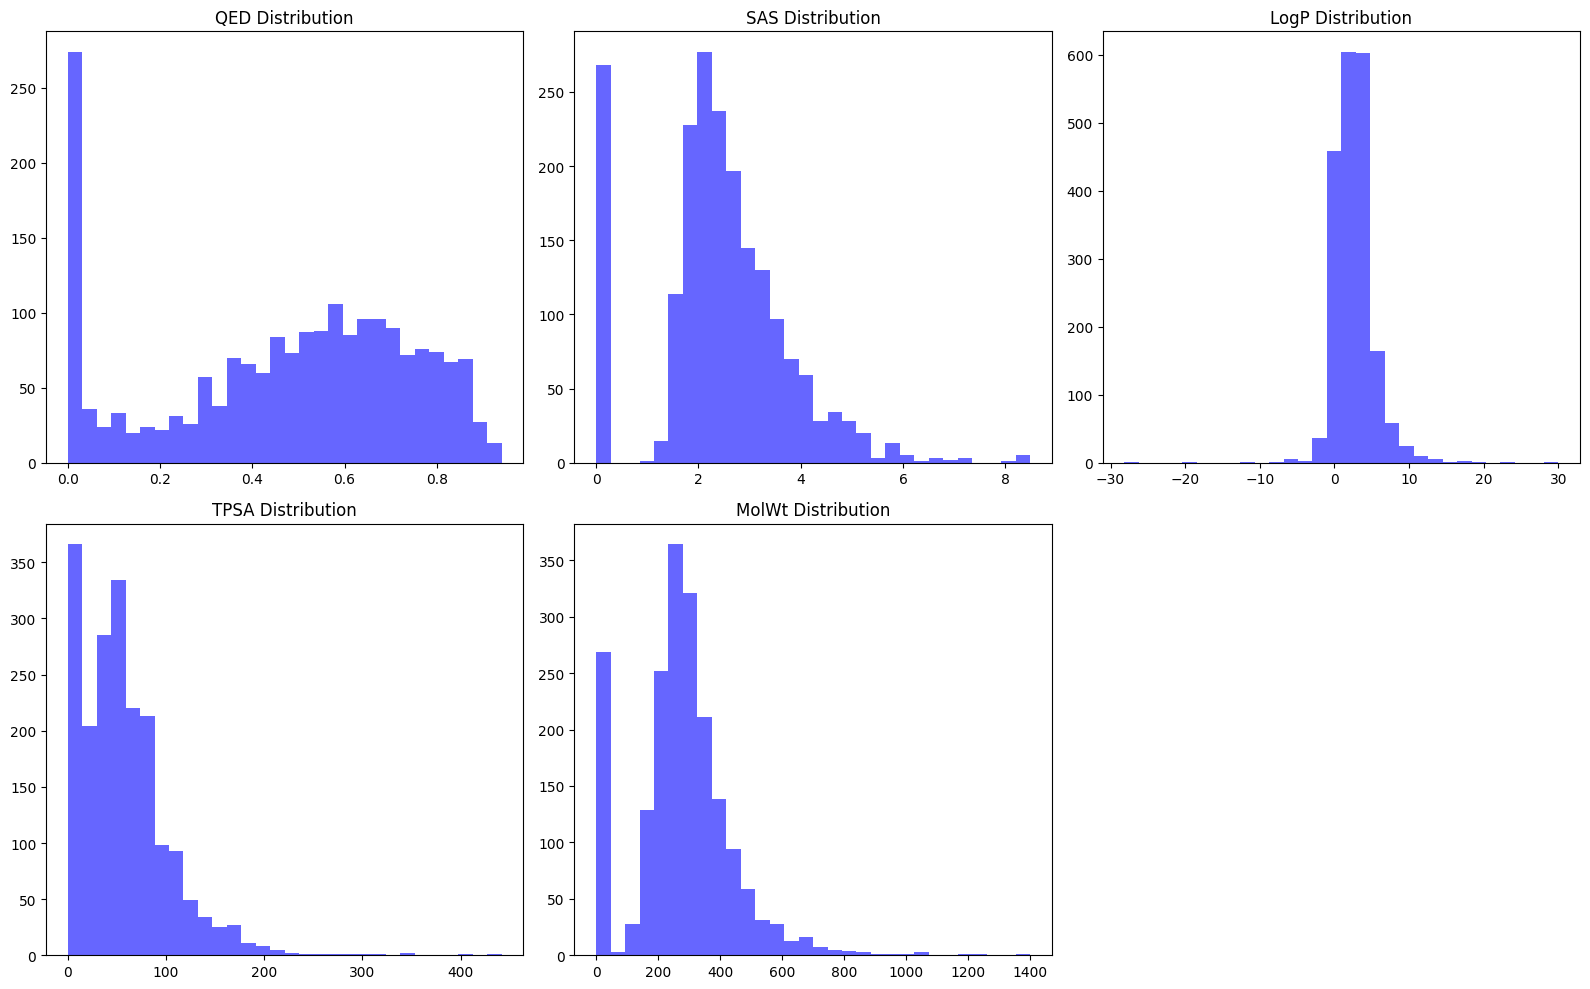

In [ ]:
# Plot property distributions
prop_names = ["QED", "SAS", "LogP", "TPSA", "MolWt"]

plt.figure(figsize=(16,10))
for i in range(5):
    plt.subplot(2,3,i+1)
    plt.hist(props_np[:,i], bins=30, color="blue", alpha=0.6)
    plt.title(f"{prop_names[i]} Distribution")
plt.tight_layout()
plt.show()


In [ ]:
# Diversity score (internal pairwise Tanimoto)
def tanimoto_diversity(mols, sample_size=200):
    vecs = []
    for m in mols[:sample_size]:
        if m:
            fp = rdMolDescriptors.GetMorganFingerprintAsBitVect(m, 2, nBits=2048)
            vecs.append(fp)

    if len(vecs) < 2:
        return 0.0

    scores = []
    for i in range(len(vecs)):
        for j in range(i+1, len(vecs)):
            sim = DataStructs.TanimotoSimilarity(vecs[i], vecs[j])
            scores.append(1 - sim)
    return np.mean(scores)

div_score = tanimoto_diversity(mols, sample_size=200)
print(f"\nDiversity (1 - Tanimoto): {div_score:.4f}")


Diversity (1 - Tanimoto): 0.8691


[11:20:30] DEPRECATION WARNING: please use MorganGenerator
[11:20:30] DEPRECATION WARNING: please use MorganGenerator
[11:20:30] DEPRECATION WARNING: please use MorganGenerator
[11:20:30] DEPRECATION WARNING: please use MorganGenerator
[11:20:30] DEPRECATION WARNING: please use MorganGenerator
[11:20:30] DEPRECATION WARNING: please use MorganGenerator
[11:20:30] DEPRECATION WARNING: please use MorganGenerator
[11:20:30] DEPRECATION WARNING: please use MorganGenerator
[11:20:30] DEPRECATION WARNING: please use MorganGenerator
[11:20:30] DEPRECATION WARNING: please use MorganGenerator
[11:20:30] DEPRECATION WARNING: please use MorganGenerator
[11:20:30] DEPRECATION WARNING: please use MorganGenerator
[11:20:30] DEPRECATION WARNING: please use MorganGenerator
[11:20:30] DEPRECATION WARNING: please use MorganGenerator
[11:20:30] DEPRECATION WARNING: please use MorganGenerator
[11:20:30] DEPRECATION WARNING: please use MorganGenerator
[11:20:30] DEPRECATION WARNING: please use MorganGenerat

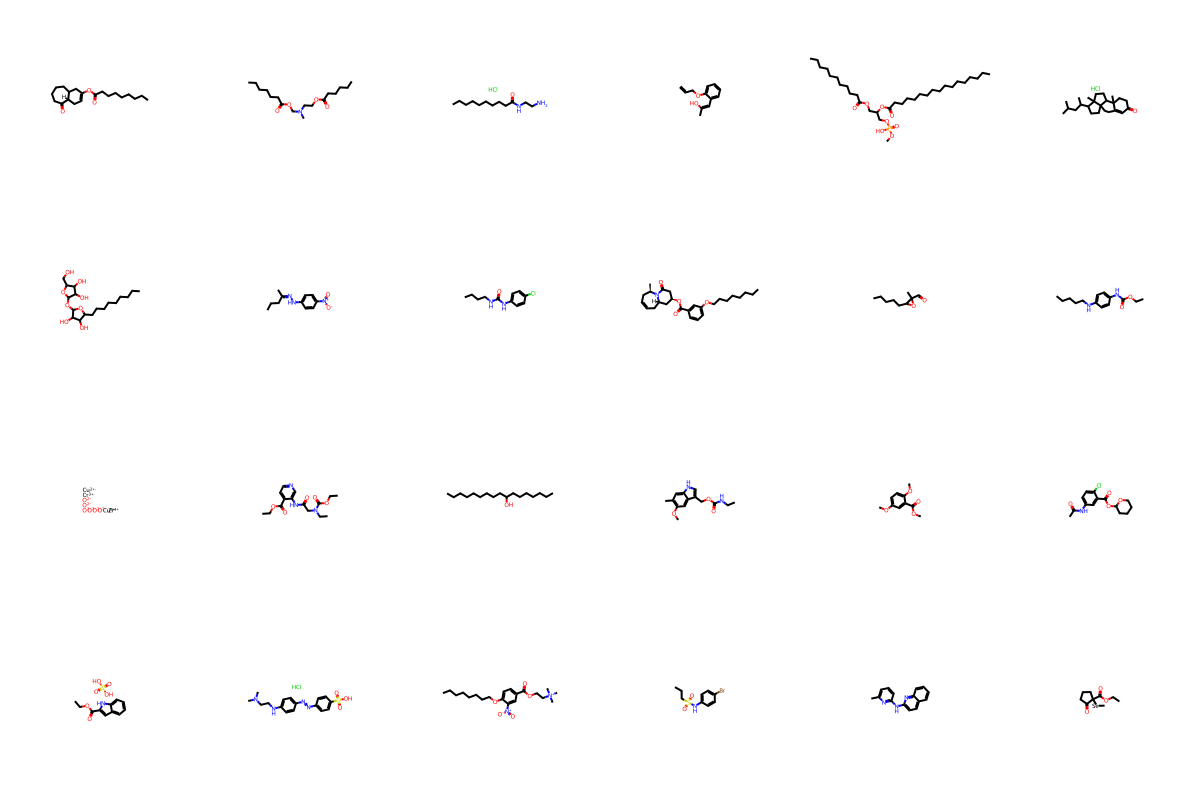


Evaluation Complete.


In [10]:

sample_mols = [m for m in mols if m is not None]
if len(sample_mols) > 24:
    sample_mols = random.sample(sample_mols, 24)

img = Draw.MolsToGridImage(sample_mols, molsPerRow=6, subImgSize=(200,200))
display(img)

print("\nEvaluation Complete.")

# Conditional molecule testing

In [ ]:
target_props = torch.tensor([[0.8, 2.5, 3.0, 120.0, 300.0]])  

In [ ]:
import json
import torch
import numpy as np

STATS_PATH = "../data/processed_5l/property_stats.json"
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

prop_cols = ["QED", "SAS", "LogP", "TPSA", "MolWt"]

with open(STATS_PATH, 'r') as f:
    loaded_stats = json.load(f)

prop_stats = {
    'min': torch.tensor([loaded_stats['min'][c] for c in prop_cols], dtype=torch.float32).to(device),
    'max': torch.tensor([loaded_stats['max'][c] for c in prop_cols], dtype=torch.float32).to(device)
}


prop_stats['range'] = (prop_stats['max'] - prop_stats['min']) + 1e-8

print("=== Loaded Normalization Stats ===")
print("Min:", prop_stats['min'].cpu().numpy())
print("Max:", prop_stats['max'].cpu().numpy())
print("Range:", prop_stats['range'].cpu().numpy())

=== Loaded Normalization Stats ===
Min: [ 3.9431723e-03  1.0000000e+00 -8.7627800e+01  0.0000000e+00
  1.0080000e+00]
Max: [9.4825125e-01 1.0000000e+01 5.9808720e+01 4.2015000e+03 1.8838697e+04]
Range: [9.4430810e-01 9.0000000e+00 1.4743652e+02 4.2015000e+03 1.8837689e+04]


In [ ]:
# Define QUERY in RAW FORM
query_raw = torch.tensor([[0.8, 2.5, 3.0, 120.0, 300.0]], dtype=torch.float32).to(device)
query_norm = (query_raw - prop_stats['min']) / prop_stats['range']
query_norm = torch.clamp(query_norm, 0.0, 1.0)

print("\n=== QUERY ===")
print("Raw Query: ", query_raw.cpu().numpy())
print("Normalized Query:", query_norm.cpu().numpy())



=== QUERY ===
Raw Query:  [[  0.8   2.5   3.  120.  300. ]]
Normalized Query: [[0.8430054  0.16666667 0.6146903  0.02856123 0.01587201]]


In [ ]:
# Sample molecules conditioning on query_norm
N_SAMPLES = 50
smiles_list = []

for _ in tqdm(range(N_SAMPLES), desc="Sampling"):
    seqs = sample_generator(generator, query_norm, (token_to_idx, idx_to_token), max_len=MAX_LEN)
    smiles = decode_smiles(seqs, idx_to_token)
    smiles_list.extend(smiles)

print(f"Generated {len(smiles_list)} SMILES.")


Sampling: 100%|██████████| 50/50 [00:08<00:00,  5.96it/s]

Generated 50 SMILES.


In [18]:
actual_props, valid_arr, mols = compute_properties(smiles_list)  # RAW outputs

# Normalize for comparison
actual_props_norm = (actual_props - prop_stats['min'].cpu().numpy()) / prop_stats['range'].cpu().numpy()
actual_props_norm = np.clip(actual_props_norm, 0.0, 1.0)

print("\nSample of normalized props:", actual_props_norm[:3])
print("Validity:", valid_arr.mean())



Sample of normalized props: [[0.84356339 0.139294   0.62888895 0.00696418 0.01623628]
 [0.86233412 0.17076854 0.61756068 0.01174104 0.01498926]
 [0.62044003 0.16921968 0.59833288 0.03355944 0.01838766]]
Validity: 0.86


[11:36:14] Can't kekulize mol.  Unkekulized atoms: 8
[11:36:14] Can't kekulize mol.  Unkekulized atoms: 2 3 4 16 18
[11:36:14] SMILES Parse Error: unclosed ring for input: 'CCOC(=O)c1cc2c(cn1C)NC(=O)c1ccccc1N3'
[11:36:14] Can't kekulize mol.  Unkekulized atoms: 3 4 5 9 10 14 15
[11:36:14] Can't kekulize mol.  Unkekulized atoms: 3 4 5 6 7 8 11 12 21
[11:36:14] Can't kekulize mol.  Unkekulized atoms: 4 5 6
[11:36:14] Can't kekulize mol.  Unkekulized atoms: 9 10 11


In [ ]:
mse = ((actual_props_norm - query_norm.cpu().numpy())**2).mean(axis=1)

# Cosine similarity (higher = better match)
cos_sim = np.array([
    np.dot(a, query_norm.cpu().numpy()[0]) / 
    (np.linalg.norm(a) * np.linalg.norm(query_norm.cpu().numpy()[0]) + 1e-8)
    for a in actual_props_norm
])

best_idx = np.argmin(mse)
worst_idx = np.argmax(mse)

print("\n=== BEST MATCH ===")
print("SMILES:", smiles_list[best_idx])
print("Props (RAW):", actual_props[best_idx])
print("Props (NORM):", actual_props_norm[best_idx])
print("MSE:", mse[best_idx])

print("\n=== WORST MATCH ===")
print("SMILES:", smiles_list[worst_idx])
print("Props (RAW):", actual_props[worst_idx])
print("Props (NORM):", actual_props_norm[worst_idx])
print("MSE:", mse[worst_idx])



=== BEST MATCH ===
SMILES: CN(Cc1cccc(N2C(=O)CSC2=S)c1)c1ccccn1
Props (RAW): [  0.80582758   2.4984772    3.0827      36.44       329.45      ]
Props (NORM): [0.84917667 0.16649747 0.61525121 0.00867309 0.01743537]
MSE: 8.728192661050799e-05

=== WORST MATCH ===
SMILES: CCN(CC(=O)Cn1c(C)c(=O)n(CC)c1=O)c1ccccc1
Props (RAW): [0. 0. 0. 0. 0.]
Props (NORM): [0.         0.         0.59434255 0.         0.        ]
MSE: 0.1479835221889722


In [21]:
print("\n---- OVERALL MATCH STATS ----")
print(f"Mean MSE: {mse.mean():.4f}")
print(f"Median MSE: {np.median(mse):.4f}")
print(f"Mean Cosine Similarity: {cos_sim.mean():.4f}")
print(f"Validity: {valid_arr.mean()*100:.2f}%")



---- OVERALL MATCH STATS ----
Mean MSE: 0.0251
Median MSE: 0.0024
Mean Cosine Similarity: 0.9353
Validity: 86.00%


# Individual molecule testing

In [ ]:
def generate_and_evaluate_one(prop_query_raw, generator, token_maps, max_len=128):
    # Convert input to tensor
    if not torch.is_tensor(prop_query_raw):
        prop_query_raw = torch.tensor([prop_query_raw], dtype=torch.float32).to(device)
    else:
        prop_query_raw = prop_query_raw.to(device)

    # Normalize 
    prop_query_norm = (prop_query_raw - prop_stats['min']) / prop_stats['range']
    prop_query_norm = torch.clamp(prop_query_norm, 0.0, 1.0)

    # Generate molecule
    generator.eval()
    with torch.no_grad():
        seqs = sample_generator(generator, prop_query_norm, token_maps, max_len=max_len)
    smiles = decode_smiles(seqs, token_maps[1])[0]  # only one molecule

    # Compute RDKit properties
    mol = Chem.MolFromSmiles(smiles)
    if mol:
        props_raw = np.array(get_props(mol))
        valid = True
    else:
        props_raw = np.zeros(5)
        valid = False

    return smiles, props_raw, valid


In [ ]:
test_raw = [0.8, 2.5, 3.0, 120, 300]
smiles, props_raw, valid = generate_and_evaluate_one(test_raw, generator, (token_to_idx, idx_to_token))
print("SMILES:", smiles)
print("Valid:", valid)
print("Generated Properties (RAW):", props_raw)


SMILES: CC(C)Cc1c(C(=O)O)c(=O)n2nc(-c3ccccc3)nc2s1
Valid: True
Generated Properties (RAW): [  0.79532507   2.51334578   2.7147      84.56       329.381     ]


In [ ]:
print("Target Query:", test_raw)
print("Absolute Error:", np.abs(props_raw - np.array(test_raw)))

Target Query: [0.8, 2.5, 3.0, 120, 300]
Absolute Error: [4.67492540e-03 1.33457826e-02 2.85300000e-01 3.54400000e+01
 2.93810000e+01]


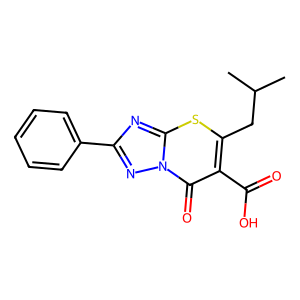

In [ ]:
from rdkit.Chem import Draw
from rdkit import Chem

if valid and smiles:
    mol = Chem.MolFromSmiles(smiles)
    img = Draw.MolsToGridImage([mol], molsPerRow=1, subImgSize=(300, 300))
    display(img)
else:
    print("Molecule was invalid — cannot visualize.")


In [33]:
norm = torch.tensor([0.7405557018093497,0.12368295660876186,0.6018468151173257,0.009953588004260494,0.009460343038888964]).to(device)

real_values = norm * prop_stats['range'] + prop_stats['min']
real_list = real_values.cpu().numpy().tolist()
print(real_list)


[0.7032558917999268, 2.1131465435028076, 1.1063995361328125, 41.81999969482422, 179.218994140625]


In [ ]:
smiles, props_raw, valid = generate_and_evaluate_one(real_list, generator, (token_to_idx, idx_to_token))
print("SMILES:", smiles)
print("Valid:", valid)
print("Generated Properties (RAW):", props_raw)


SMILES: CCCC(=O)Nc1ccc(OCCN(C)C)cc1.Cl
Valid: True
Generated Properties (RAW): [  0.83794229   1.78427519   2.7874      41.57       286.803     ]
